In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Not needed in notebook

In [2]:
# Training settings
# parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                     help='SGD momentum (default: 0.5)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='disables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

# torch.manual_seed(args.seed)
# if args.cuda:
#     torch.cuda.manual_seed(args.seed)


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# Running from the root makes things easy

In [3]:
%cd ../..

/media/yasen/storage/studies/uoe/mlp/sem2/mlp-03


In [4]:
from src.datautils.sandia import SandiaDataProvider

# Setup data provider

In [5]:
train_batch_size = 64
test_batch_size = 8

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=train_batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('datasets/mnist', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=test_batch_size, shuffle=True)

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='datasets/sandia/',
                                  img_size=28)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='datasets/sandia/',
                                  img_size=28,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
# Reload these every time you start an epoch
train_loader = train_data.get_image_batch_iterator(train_batch_size)
test_loader = test_data.get_image_batch_iterator(test_batch_size)

# Define models

In [6]:
lr = 0.1
momentum = 0.5
cuda = True

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = autoencoder()
if cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Train models

In [7]:
log_interval = 50
losses = []
def train(epoch):
    model.train()
    # Get new gen object at every epoch
    train_loader = train_data.get_image_batch_iterator(train_batch_size)
    for batch_idx, (data, _) in enumerate(train_loader):
        # Autoencoder
        target = data
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if batch_idx % log_interval == 0:
            print('Train Epoch: {0} Loss: {1:.6f}'.format(epoch, loss.data[0]))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    # Get a fresh generator object
    test_loader = test_data.get_image_batch_iterator(test_batch_size)
    for data, _ in test_loader:
        # Autoencoder
        target = data
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
# test()

Train Epoch: 1 Loss: 1.025591
Train Epoch: 1 Loss: 0.771838
Train Epoch: 1 Loss: 1.055030
Train Epoch: 1 Loss: 1.083452
Train Epoch: 2 Loss: 1.056082
Train Epoch: 2 Loss: 0.680351
Train Epoch: 2 Loss: 0.914006
Train Epoch: 2 Loss: 0.837143
Train Epoch: 3 Loss: 0.681910
Train Epoch: 3 Loss: 0.671756
Train Epoch: 3 Loss: 0.595068
Train Epoch: 3 Loss: 0.557312
Train Epoch: 4 Loss: 0.599317
Train Epoch: 4 Loss: 0.746425
Train Epoch: 4 Loss: 0.599915
Train Epoch: 4 Loss: 0.613108
Train Epoch: 5 Loss: 0.620340
Train Epoch: 5 Loss: 0.926396
Train Epoch: 5 Loss: 0.585897
Train Epoch: 5 Loss: 0.638385
Train Epoch: 6 Loss: 0.595913
Train Epoch: 6 Loss: 0.713844
Train Epoch: 6 Loss: 0.551340
Train Epoch: 6 Loss: 0.804433
Train Epoch: 7 Loss: 0.495912
Train Epoch: 7 Loss: 0.617494
Train Epoch: 7 Loss: 0.618065
Train Epoch: 7 Loss: 0.506910
Train Epoch: 8 Loss: 0.566720
Train Epoch: 8 Loss: 0.496260
Train Epoch: 8 Loss: 0.713822
Train Epoch: 8 Loss: 0.532306
Train Epoch: 9 Loss: 0.698055
Train Epoc

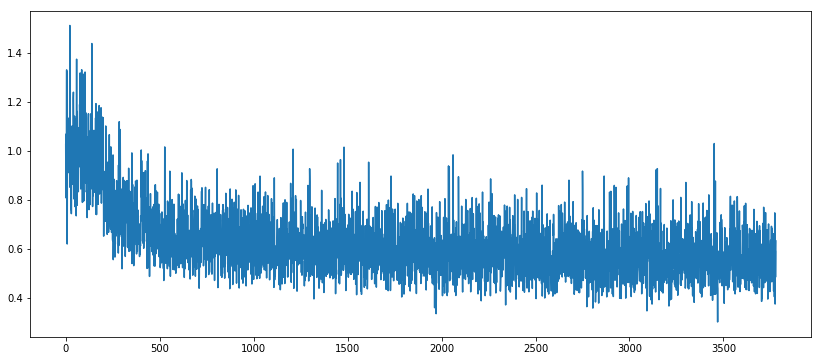

In [8]:
plt.figure(figsize=(14,6))
plt.plot(losses);

In [9]:
data, output = None, None
test_loader = train_data.get_image_batch_iterator(test_batch_size)

for batch_idx, (data, _) in enumerate(test_loader):
    target = data
    if cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    break

In [10]:
encoded = model.encoder(data)
eps = Variable(torch.randn(encoded.size())).cuda()
encoded_jittered = encoded + eps * 10

In [11]:
jittered_reconstruction = model.decoder(encoded_jittered)

In [12]:
start, end = data[5, :], data[3, :]
fades = start
for i in range(1, test_batch_size - 1):
    coeff = i / (test_batch_size - 1)
    new = end * coeff + start * (1 - coeff)
    fades = torch.cat((fades, new), 0)
fades = torch.cat((fades, end), 0) 

In [13]:
originals = data.view(test_batch_size, 28, 28).cpu().data.numpy()
reconstructions = output.view(test_batch_size, 28, 28).cpu().data.numpy()
jittered = jittered_reconstruction.view(test_batch_size, 28, 28).cpu().data.numpy()
faded = fades.view(test_batch_size, 28, 28).cpu().data.numpy()

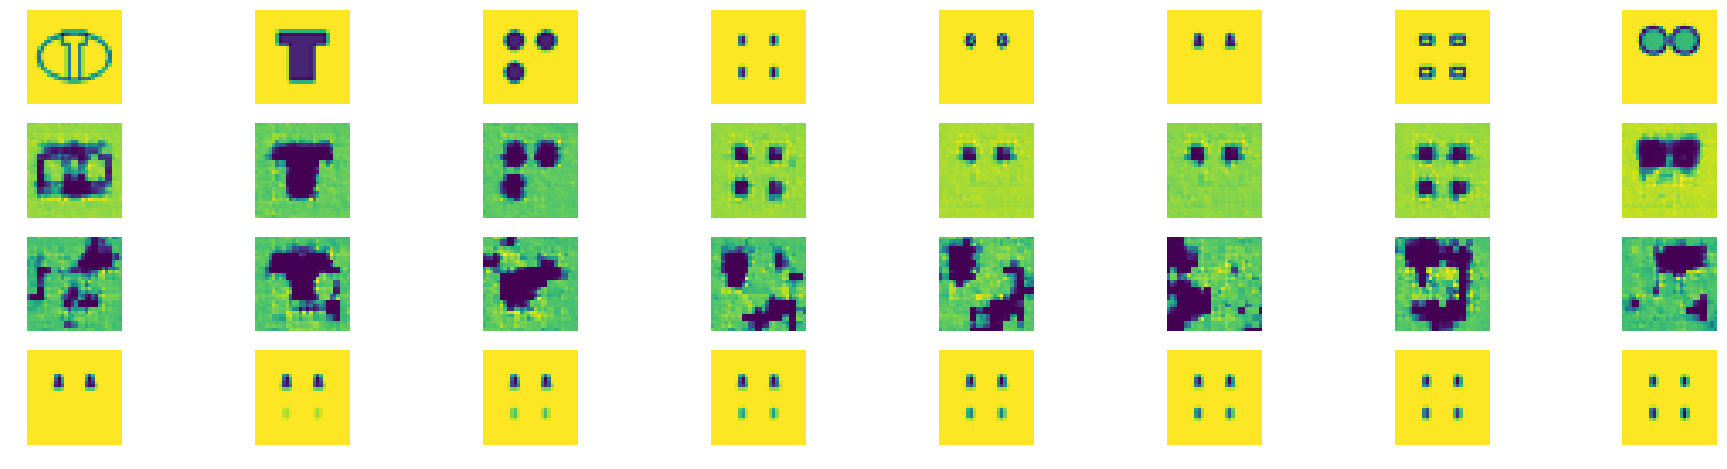

In [14]:
def show_batch_of_images(img_batch, img_size=(1,1), grid_size=None):
    # How many squares for a square grid that can fit all images
    if grid_size == None:
        grid_size = math.ceil(math.sqrt(len(img_batch)))
        grid_size = (grid_size, grid_size)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(img_size[0] * grid_size[0], img_size[1] * grid_size[1]))
    # Turn the 2d array of axes to a 1d array
    axs = axs.flatten()
    for i, img in enumerate(img_batch):
        axs[i].imshow(img.reshape(28,28))
    # Do this separately in case the number of images we want to show is not a perfect square
    for i in range(grid_size[0] * grid_size[1]):
        axs[i].axis('off')
    plt.show()

show_batch_of_images(np.concatenate([originals, reconstructions, jittered, faded]), img_size=(test_batch_size, 1), grid_size=(4, test_batch_size))